<img src = 'https://velog.velcdn.com/images/krec7748/post/75ca5698-db29-436d-8215-216865670787/image.png'>

* 논문 : https://arxiv.org/pdf/1608.06993

In [1]:
import torch
from torch import nn, Tensor
from torchsummary import summary

In [21]:
class Bottleneck(nn.Module):
    '''
    4 * k 에서 4는 하이퍼 파라미터!!
    '''
    def __init__(self, in_channels, k):
        super().__init__()
        
        self.residual = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, 4 * k, kernel_size = 1, padding = 0, bias  = False),
            nn.BatchNorm2d(4 * k),
            nn.ReLU(),
            nn.Conv2d(4 * k , k, kernel_size = 3, padding = 1, bias  = False),
        )
    def forward(self, x):
        return torch.cat([self.residual(x), x], dim = 1)

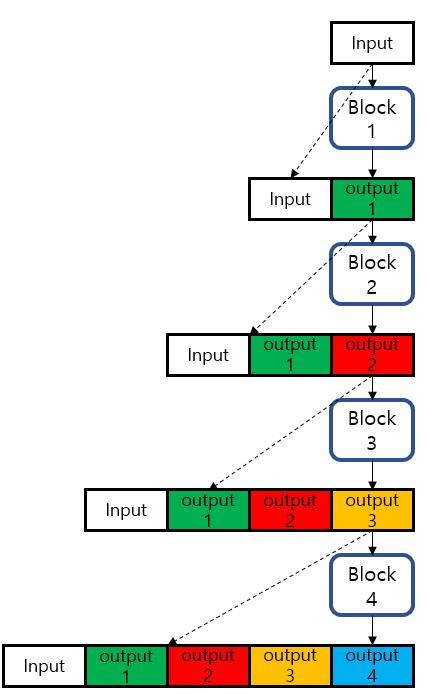

* 그림 : 신재호

In [57]:
class Transition(nn.Module):
    def __init__(self, in_channels, theta = 0.5):
        super().__init__()
        self.transition = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, int(in_channels * theta), kernel_size = 1, bias = False),
            nn.AvgPool2d(2,2)
        )
    def forward(self, x):
        return self.transition(x)

In [78]:
class DenseNet_blueprint(nn.Module):
    '''
    theta는 하이퍼 파리미터임!!!
    '''
    def __init__(self, num_blocks, growth_rate, num_classes = 1000, theta = 0.5):
        super().__init__()
        
        assert len(num_blocks) == 4
        
        self.k = growth_rate
        self.theta = theta
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 2 * self.k, kernel_size = 7, stride = 2, padding = 3, bias = False),
            nn.BatchNorm2d(2 * self.k),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.dense_channels = 2 * self.k
        
        dense_blocks = []
        for i in range(len(num_blocks)-1):
            dense_blocks.append(self._make_dense_block(num_blocks[i]))
        dense_blocks.append(self._make_dense_block(num_blocks[len(num_blocks)-1], last_stage = True))
        self.dense_blocks = nn.Sequential(*dense_blocks)
        
        self.avg = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.dense_channels, num_classes)
        
        self._init_layer()
    
    def _make_dense_block(self, num_block, last_stage = False):
        layers = []
        for _ in range(num_block):
            layers.append(Bottleneck(self.dense_channels, self.k))
            self.dense_channels += self.k
        if last_stage:
            layers.append(nn.Sequential(
                nn.BatchNorm2d(self.dense_channels),
                nn.ReLU())
                         )
        else:
            layers.append(Transition(self.dense_channels, self.theta))
            # assert self.dense_channels % 2 == 0
            self.dense_channels = int(self.dense_channels * self.theta)

        return nn.Sequential(*layers)
    
    def _init_layer(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode = 'fan_out', nonlinearity = 'relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.maxpool(out)
        out = self.dense_blocks(out)
        out = self.avg(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [79]:
def DenseNet(num_layers, num_classes, theta = 0.5):
    if num_layers == 121:
        return DenseNet_blueprint(num_blocks = [6, 12, 24, 16], growth_rate = 32, num_classes = num_classes, theta = theta)
    elif num_layers == 169:
        return DenseNet_blueprint(num_blocks = [6, 12, 32, 32], growth_rate = 32, num_classes = num_classes, theta = theta)
    elif num_layers == 201:
        return DenseNet_blueprint(num_blocks = [6, 12, 48, 32], growth_rate = 32, num_classes = num_classes, theta = theta)
    elif num_layers == 264:
        return DenseNet_blueprint(num_blocks = [6, 12, 64, 48], growth_rate = 32, num_classes = num_classes, theta = theta)
    else:
        raise Exception('121, 169, 201, 264 is available!!!!')

In [80]:
import torchinfo
torchinfo.summary(DenseNet(121, 1000), (1,3,224,224), device='cpu')

Layer (type:depth-idx)                        Output Shape              Param #
DenseNet_blueprint                            [1, 1000]                 --
├─Sequential: 1-1                             [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-2                              [1, 64, 56, 56]           --
├─Sequential: 1-3                             [1, 1024, 7, 7]           --
│    └─Sequential: 2-4                        [1, 128, 28, 28]          --
│    │    └─Bottleneck: 3-1                   [1, 96, 56, 56]           45,440
│    │    └─Bottleneck: 3-2                   [1, 128, 56, 56]          49,600
│    │    └─Bottleneck: 3-3                   [1, 160, 56, 56]          53,760
│    │    └─Bottleneck: 3-4                   [1, 192, 56, 56]          57,920


In [35]:
from torchvision.models import densenet121
model = densenet121()
torchinfo.summary(model, (1,3,224,224), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [1, 1000]                 --
├─Sequential: 1-1                        [1, 1024, 7, 7]           --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 64, 56, 56]           --
│    └─_DenseBlock: 2-5                  [1, 256, 56, 56]          --
│    │    └─_DenseLayer: 3-1             [1, 32, 56, 56]           45,440
│    │    └─_DenseLayer: 3-2             [1, 32, 56, 56]           49,600
│    │    └─_DenseLayer: 3-3             [1, 32, 56, 56]           53,760
│    │    └─_DenseLayer: 3-4             [1, 32, 56, 56]           57,920
│    │    └─_DenseLayer: 3-5             [1, 32, 56, 56]           62,080
│    │    └─_DenseLayer: 3-6             [1, 32, 56, 56]     